# Modelling irregular bodies shape via ANNs
In this notebook we explore the possibility to use ANNs to represent the generic shape of an irregular body and be trained to reproduce a known gravitational potential field.

To get statically stable asteroids we use results from MPIA work by Francesco Biscani obtained during simulation of protoplanetary formation made by large n-body simulations. Data are included as a submodule in the git project.

To run this notebook create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib
 conda install -c open3d-admin open3d
```

And you will need tensorflow (CPU is enough) for the ANN part


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Loading and visualizing an asteroid as a point cloud

In [2]:
# We import the data from MPIA containing pseudo-stable asteroid shapes
f = h5py.File('sample_vis_data/sample_01/state_10567.hdf5','r')
f2 = h5py.File('sample_vis_data/sample_01/global.hdf5', 'r')

In [3]:
# The file state_ ... contains the positions of all particles as well as the indices
# of those belonging to a cluster. Here we extract the largest ones.
dims = [(len(f[cluster][()]), cluster) for cluster in f.keys() if 'cluster' in cluster]
largest_clusters = sorted(dims,reverse=True)

In [4]:
# We have ordered the largest asteroids, we now extract positions for one in particular
rank = 4
print("Target: ", largest_clusters[rank][1])
# The particles idxs for this cluster
idx = f[largest_clusters[rank][1]][()]
# The particle radius
radius = f2['radius'][()]
# Particle positions
x_raw = f['x'][()][idx]
y_raw = f['y'][()][idx]
z_raw = f['z'][()][idx]
print("Diameter: ", 2 * radius)

Target:  cluster_2400
Diameter:  0.00043088693800637674


In [5]:
from sklearn.neighbors import NearestNeighbors
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x_raw, np.append(y_raw,z_raw))
point_cloud = point_cloud.reshape((3,len(x_raw)))
point_cloud = np.transpose(point_cloud)

nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(point_cloud)
distances, indices = nbrs.kneighbors(point_cloud)

print("Minimum distance between particles: ", min(distances[:,1]))
print("Maximum distance between particles: ", max(distances[:,1]))

# We take out particles that are not "touching" at least two neighbours
unstable_points = np.where(distances[:, 3]> 2 * radius * 1.01)[0]
print("Number of unstable points: ", len(unstable_points))
x = np.delete(x_raw, unstable_points, 0)
y = np.delete(y_raw, unstable_points, 0)
z = np.delete(z_raw, unstable_points, 0)

Minimum distance between particles:  0.00042108838275198475
Maximum distance between particles:  0.0005132013991266676
Number of unstable points:  5


In [6]:
# We subtract the mean so that the origin is the center of figure
x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.mean(z)
# We normalize so that the z axis is at most one
x = x / max(abs(z))
y = y / max(abs(z))
z = z / max(abs(z))
radius = radius /  max(abs(z)) *1e5*6
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x, np.append(y,z))
point_cloud = point_cloud.reshape((3,len(x)))
point_cloud = np.transpose(point_cloud)

### Visualization via matplotlib

<IPython.core.display.Javascript object>


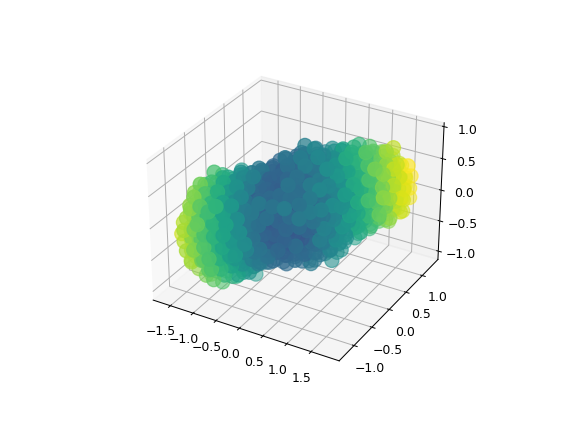

In [7]:
# We color the points w.r.t. their distance to the center
color = [np.linalg.norm([point]) for point in point_cloud] 
# And visualize the masses
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c = color, s = radius)


### Visualization via open3d

In [8]:
import numpy as np
import open3d as o3d

colors = np.exp(-np.array(color))
colors = np.append(np.append(colors, colors), colors).reshape((3, len(color))).transpose()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.colors = o3d.utility.Vector3dVector(colors)


hull, _ = pcd.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([pcd, hull_ls])

# Computing the gravitational potential of an asteroid (point cloud) in a point 
The Canvendish constant is not included (or $G=1$), so that we have:
$$
U = - \sum_{i=1}^N \frac{m_i}{|\mathbf x - \mathbf r_i|}
$$
where, assuming the asteroid with a unitary mass $m_i = 1/N$, hence:
$$
U = - \frac 1N \sum_{i=1}^N \frac{1}{|\mathbf x - \mathbf r_i|}
$$

In [9]:
def U(r, point_cloud):
    retval =0;
    for point in point_cloud:
        retval = retval + 1./np.linalg.norm(r-point)
    return - retval / len(point_cloud)

In [11]:
%timeit U(np.array([2,2,2]), point_cloud=point_cloud)

15.9 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Representing the asteroid via a neural network
Here we represent the polar equation for the asteroid surface as a FFNN

In [12]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [13]:
# Initializing a FFNN with three inputs (cartesian components of the unit direction vector) 
# and one output (the asteroid radius)
initializer_w = keras.initializers.RandomNormal(mean=0., stddev=1.)
initializer_w = keras.initializers.RandomUniform(minval=-1.1, maxval=1.1)
initializer_b = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)

model = Sequential()
model.add(Dense(10, input_dim=3, activation='tanh', kernel_initializer=initializer_w, bias_initializer=initializer_b))
model.add(Dense(10, activation='tanh', kernel_initializer=initializer_w, bias_initializer=initializer_b))
model.add(Dense(10, activation='tanh', kernel_initializer=initializer_w, bias_initializer=initializer_b))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer_w, bias_initializer=initializer_b))

In [14]:
inputs = []
u, v = np.linspace(0, 1, 40), np.linspace(0, 1, 40)
theta, phi = 2 * np.pi * u, np.arccos(2*v-1)
for p in phi:
    for t in theta:
        inputs.append(np.array([np.sin(p)*np.cos(t), np.sin(p)*np.sin(t), np.cos(p)]))
inputs = np.array(inputs)

In [15]:
r = model.predict(inputs)

In [16]:
THETA, PHI = np.meshgrid(theta, phi)
R = np.reshape(r, (40,40))

<IPython.core.display.Javascript object>


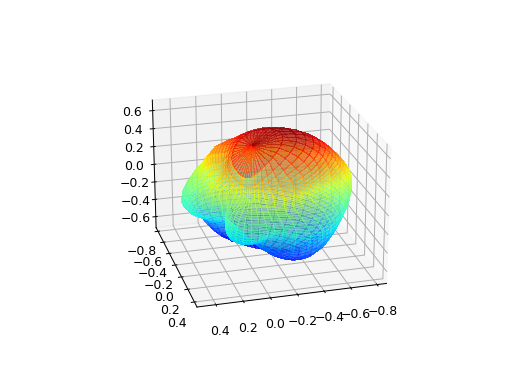

In [17]:
X = R * np.sin(PHI) * np.cos(THETA)
Y = R * np.sin(PHI) * np.sin(THETA)
Z = R * np.cos(PHI)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, cmap=plt.get_cmap('jet'),
    linewidth=0, antialiased=False, alpha=0.5)

# Computing the gravitational potential of an asteroid (represented by an ANN) in a point 

We have a representation of the asteroid volume given by our ANN, we may then assume a uniform internal density and  compute the resulting potential at a given point $\mathbf x$ as:

$$
U = \int_V \rho \frac1{|\mathbf r - \mathbf x|} dV = \rho \int_V \frac{dV}{|\mathbf r - \mathbf x|} 
$$

to compute the integral we use Monte Carlo integration methods, that is we sample N points in a volume V = [-1,1]x[-1,1]x[-1,1] that we know contains our asteroid (as ensured by the sigmoid activation function of the last layer). We then approximate:

$$
U(\mathbf x) = \rho\frac V N  \sum_i^N \left\{\begin{array}{ll}\frac{1}{|\mathbf r_i - \mathbf x|} & \mbox{inside the asteroid} \\ 0 &  \mbox{otherwise}  \end{array}\right.
$$

In [42]:
def U_quadrature(r, points, model):
    norms = np.linalg.norm(points, axis=1)
    inside = norms < np.reshape(model.predict(grid / np.reshape(norms, (len(grid),1))), (len(grid),))
    retval = sum(1./np.linalg.norm(r-points[inside], axis=1))
    return retval / np.count_nonzero(inside)

N = 3000
grid = np.random.random((N,3)) * 2 -1

In [43]:
class sphere:
    def predict(self, x):
        return np.array([1]*len(x))
#asteroid = sphere()
asteroid = model

U_quadrature(np.array([3.,3.,-3.]), grid, asteroid)

0.18487688906144426

In [37]:
U(np.array([3.,3.,-3.]), point_cloud=point_cloud)

-0.1934723785973019